# GPT Functionality extraction

In [1]:
import json
import openai  # Ensure this import is here
# new
from openai import OpenAI
from openai import AsyncOpenAI
#!pip install --upgrade openai ## another way to update
#!openai migrate #use this to update the version
print('version:',openai.__version__)


import nest_asyncio
nest_asyncio.apply()

import asyncio
import pandas as pd
import os
from tqdm.asyncio import tqdm

version: 1.13.3


In [2]:
# Load API key from 'config.json'
with open('../config.json', 'r') as f:
    config = json.load(f)
    api_key = config['OPENAI_API_KEY']

# Initialize the OpenAI client with the API key
client = AsyncOpenAI(api_key=api_key)

### Basic api call 

In [3]:
async def generate_text_completion(prompt):
    completion = await client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a witty assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return completion

### Test

In [4]:
## Test
prompt = "Tell me a joke about AI."
completion = await generate_text_completion(prompt)

# Adjusted access to the message content
print(completion.choices[0].message.content)

Why did the AI go to therapy? Because it had too many unresolved loops!


## Use open AI to convert the documents

In [5]:
# Assuming the convert_code_to_doc function is defined elsewhere and it's asynchronous
async def convert_code_to_doc(code):
    prompt = "What is the function of this code?\n\n" + code
    completion = await generate_text_completion(prompt)
    return completion.choices[0].message.content

### iterate

#### Quality of life, add a loading bar

!pip install tqdm

!pip install --upgrade bottleneck


## Process files (Async)

In [6]:
async def process_file(task, filename, task_path):
    file_path = os.path.join(task_path, filename)
    with open(file_path, 'r') as file:
        content = file.read()
    analysis_result = await convert_code_to_doc(content)
    return {'task': task, 'analysis_text': analysis_result}

async def process_tasks(tasks, directory_path):
    tasks_data = []
    for task in tasks:
        task_path = os.path.join(directory_path, task)
        files = [f for f in os.listdir(task_path) if f.endswith('.cpp')]
        for filename in tqdm(files, desc=f'Processing {task}', unit='file'):
            file_data = await process_file(task, filename, task_path)  # Ensure this is properly awaited
            tasks_data.append(file_data)
    return tasks_data


In [7]:
import asyncio
import pandas as pd

# Assuming the definitions of convert_code_to_doc, process_file, and process_tasks are as before

# Directory containing the .cpp files
directory_path = 'tasks/'

# List of tasks to categorize files into
tasks = [
    "A.I._War", "Alien_Language", "Ample_Syrup",
    "A_Digging_Problem", "All_Your_Base", "Apocalypse_Soon",
    "Ace_in_the_Hole", "Allergy_Testing", "Are_We_Lost_Yet?",
    "Aerobics", "Alphabet_Cake",
    "Airport_Walkways", "Alphabetomials"
]

# Adjusted approach for running the async process in an already running event loop environment
# Directly await the asynchronous operation
tasks_data = await process_tasks(tasks, directory_path)  # This directly uses await
df = pd.DataFrame(tasks_data)

# Proceed to save the DataFrame to CSV as before
df.to_csv('analysis_dataset.csv', index=False)

Processing Alphabetomials: 100%|██████████████| 10/10 [00:25<00:00,  2.54s/file]


## Basic model with TFIDF

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load dataset
df = pd.read_csv('analysis_dataset.csv')

# Feature extraction: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(df['analysis_text']).toarray()

# Label encoding
labels = pd.get_dummies(df['task'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)

# Define a simple neural network model for classification
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(labels.shape[1], activation='softmax')  # Output layer nodes equal to number of tasks
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/100
3/3 [==============================] - 1s 75ms/step - loss: 2.5653 - accuracy: 0.0444 - val_loss: 2.5503 - val_accuracy: 0.2000
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 2.4737 - accuracy: 0.8111 - val_loss: 2.5212 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 2.3824 - accuracy: 1.0000 - val_loss: 2.4789 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 2.2665 - accuracy: 1.0000 - val_loss: 2.4217 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 2.1135 - accuracy: 1.0000 - val_loss: 2.3456 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.9139 - accuracy: 1.0000 - val_loss: 2.2393 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.6651 - accuracy: 1.0000 - val_loss: 2.1052 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===

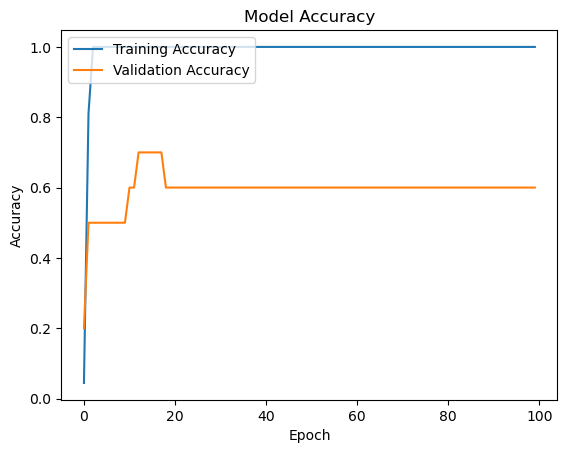

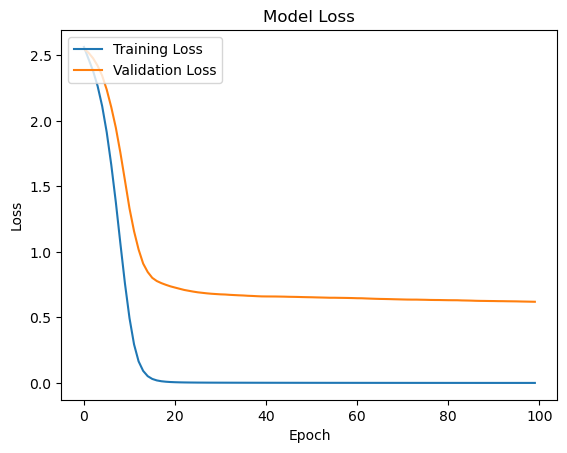

In [12]:
import matplotlib.pyplot as plt


# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()